In [5]:
import pandas as pd
# from google.colab import files
import matplotlib.pyplot as plt
from uuid import uuid4
import os
import getpass

from langchain_core.documents import Document
from langchain_qdrant import QdrantVectorStore

from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage

# rag
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser
from langchain.prompts import ChatPromptTemplate

In [ ]:
# Загрузка файла
uploaded = files.upload()

Saving dataset_clean.csv to dataset_clean.csv


In [ ]:
file = list(uploaded.keys())[0]
df = pd.read_csv(file)
df.head()

,page_url,image_url,tvshow_title,description
0,https://myshows.me/view/7718/,https://media.myshows.me/shows/760/9/49/9492ce...,Шерлок,История о Шерлоке Холмсе и докторе Ватсоне в Л...
1,https://myshows.me/view/11945/,https://media.myshows.me/shows/760/d/d1/dd10e6...,Игра престолов,"Игра Престолов — американский фэнтези-сериал, ..."
2,https://myshows.me/view/45/,https://media.myshows.me/shows/760/f/c3/fc37c3...,Сверхъестественное,"Больше десяти лет назад это шоу начиналось, ка..."
3,https://myshows.me/view/2/,https://media.myshows.me/shows/760/2/a9/2a9328...,Теория большого взрыва,"Теория большого взрыва это, уже ставший класси..."
4,https://myshows.me/view/187/,https://media.myshows.me/shows/760/0/c2/0c2961...,Во все тяжкие,"Культовый сериал о том, что школьный учитель, ..."


In [6]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

In [ ]:
#Все данные (вектора + метаданные) будут сохраняться в папку db/qdrant_db
client = QdrantClient(
    path='db/qdrant_db',
    )

In [ ]:
#Cоздаём в Qdrant новую таблицу для хранения векторов.
client.create_collection(
    collection_name="demo_collection",
    vectors_config=VectorParams(size=768, distance=Distance.COSINE), #размерность векторов (длина эмбеддинга) | косинусное сходство
)

True

In [ ]:
!nvidia-smi

Thu Oct  2 12:12:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P0             27W /   70W |    1218MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
# создание модели эмбедингов
from langchain_huggingface import HuggingFaceEmbeddings

model_name = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2" # модель которая принимает текст и возвращает его вектороное представение
model_kwargs = {'device': 'cuda'}
encode_kwargs = {'normalize_embeddings': True, 'batch_size':128} # нормализуем векторы до длины 1, обрабатываем пакетами по 128

embeddings_model = HuggingFaceEmbeddings( # объект модели
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

KeyboardInterrupt: 

📊 Статистика по количеству слов:
count    5256.000000
mean       63.832192
std        45.922538
min         1.000000
25%        31.000000
50%        54.000000
75%        85.000000
max       559.000000
Name: word_count, dtype: float64


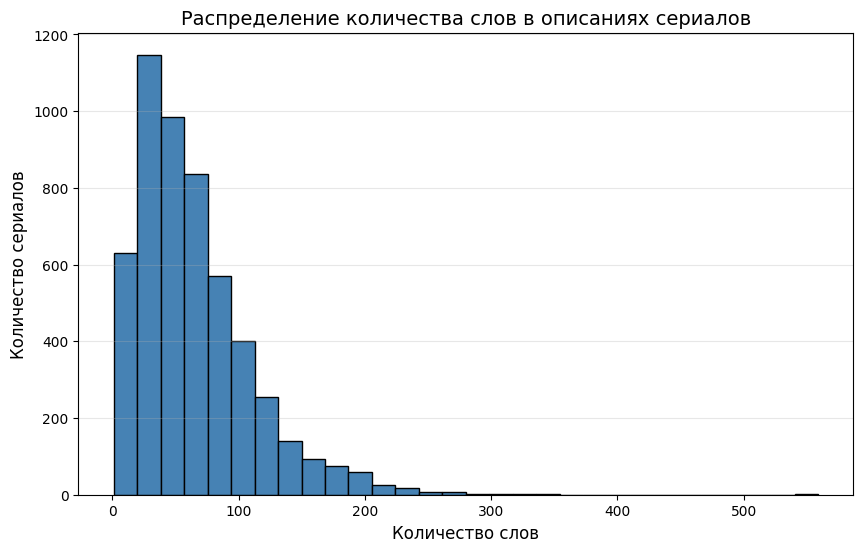

In [ ]:
# Считаем количество слов в каждом описании
df['word_count'] = df['description'].apply(lambda x: len(str(x).split()))

# Общая статистика
print("📊 Статистика по количеству слов:")
print(df['word_count'].describe())

# Строим гистограмму
plt.figure(figsize=(10,6))
plt.hist(df['word_count'], bins=30, color='steelblue', edgecolor='black')
plt.title("Распределение количества слов в описаниях сериалов", fontsize=14)
plt.xlabel("Количество слов", fontsize=12)
plt.ylabel("Количество сериалов", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:

# Удаляем слишком короткие описания
df = df[df['word_count'] >= 5].reset_index(drop=True)

# Функция для разбиения текста на чанки по 80-100 слов
def chunk_text(text, chunk_size=100, overlap=20):
    words = text.split()
    chunks = []
    start = 0
    while start < len(words):
        end = start + chunk_size
        chunk = " ".join(words[start:end])
        chunks.append(chunk)
        # Перекрытие, чтобы не потерять контекст между кусками
        start += chunk_size - overlap
    return chunks

# Создаём новый список записей с чанками
processed_rows = []
for idx, row in df.iterrows():
    text = row['description']
    word_count = len(text.split())

    # Если текст длинный разбиваем его на чанки
    if word_count > 100:
        chunks = chunk_text(text, chunk_size=100, overlap=20)
        for i, chunk in enumerate(chunks):
            processed_rows.append({
                "page_url": row['page_url'],
                "image_url": row['image_url'],
                "tvshow_title": row['tvshow_title'],
                "description": chunk,
                "chunk_id": f"{idx}_{i}",
                "original_length": word_count
            })
    else:
        # Если короткий — добавляем как есть
        processed_rows.append({
            "page_url": row['page_url'],
            "image_url": row['image_url'],
            "tvshow_title": row['tvshow_title'],
            "description": text,
            "chunk_id": f"{idx}_0",
            "original_length": word_count
        })

# Новый датафрейм с подготовленными текстами
df_chunks = pd.DataFrame(processed_rows)

# Проверим результаты
print("Количество строк после чанкинга:", len(df_chunks))
display(df_chunks.head(5))

Количество строк после чанкинга: 6344


,page_url,image_url,tvshow_title,description,chunk_id,original_length
0,https://myshows.me/view/7718/,https://media.myshows.me/shows/760/9/49/9492ce...,Шерлок,История о Шерлоке Холмсе и докторе Ватсоне в Л...,0_0,139
1,https://myshows.me/view/7718/,https://media.myshows.me/shows/760/9/49/9492ce...,Шерлок,презрения к интеллектуальному уровню окружающи...,0_1,139
2,https://myshows.me/view/11945/,https://media.myshows.me/shows/760/d/d1/dd10e6...,Игра престолов,"Игра Престолов — американский фэнтези-сериал, ...",1_0,10
3,https://myshows.me/view/45/,https://media.myshows.me/shows/760/f/c3/fc37c3...,Сверхъестественное,"Больше десяти лет назад это шоу начиналось, ка...",2_0,170
4,https://myshows.me/view/45/,https://media.myshows.me/shows/760/f/c3/fc37c3...,Сверхъестественное,путь от пухлых щечек и дурацких стрижек до обр...,2_1,170


In [ ]:
# Создаём список документов
documents = []

for _, row in df_chunks.iterrows():
    content = row['description']  # это уже чанк или описание

    # Метаданные для каждого документа
    metadata = {
        "title": row['tvshow_title'],
        "page_url": row['page_url'],
        "image_url": row['image_url'],
        "chunk_id": row['chunk_id'],
        "original_length": row['original_length'],
        "source": "tvshows",
    }

    documents.append(Document(page_content=content, metadata=metadata))

  # page_contant - текст для эмбединга
  # metadata - полезная информация которую выводим
  # uuids - уник. для Qdrant

# Генерация UUID для всех документов
uuids = [str(uuid4()) for _ in range(len(documents))]

print(f"✅ Создано {len(documents)} документов с UUID")

✅ Создано 6344 документов с UUID


In [ ]:
documents[0]

Document(metadata={'title': 'Шерлок', 'page_url': 'https://myshows.me/view/7718/', 'image_url': 'https://media.myshows.me/shows/760/9/49/9492ce09d3a31c32ba559f5936dac888.jpg', 'chunk_id': '0_0', 'original_length': 139, 'source': 'tvshows'}, page_content='История о Шерлоке Холмсе и докторе Ватсоне в Лондоне начала двадцать первого века успела прославиться не только как одна из самых стильных и интригующих экранизаций рассказов сэра Артура Конан-Дойла, но и как шоу, создатели которого заставляют фанатов изнывать в ожидании новых серий не меньше пары-тройки мучительных лет. Ожидание, впрочем, того стоит.Хромающий афганский ветеран ищет соседа по квартире и по совету знакомого отправляется в морг к возможному кандидату. К счастью, живому — но с характером, являющим собой ядерный коктейль из социопатии, презрения к интеллектуальному уровню окружающих и прочих милых личностных качеств, включая неоспоримую гениальность. Лондон, тем временем, сотрясает череда необъяснимых убийств,')

In [ ]:
#VectorStore на базе Qdrant, хранить твои документы с эмбеддингами
vector_store = QdrantVectorStore(
    client=client,
    collection_name="demo_collection",
    embedding=embeddings_model
)

In [ ]:
#загрузка документов батчами
from tqdm import tqdm

batch_size = 256
total_batches = (len(documents) + batch_size - 1) // batch_size


with tqdm(total=total_batches, desc="Добавление батчей в Qdrant") as pbar:
    for i in range(0, len(documents), batch_size):
        batch_docs = documents[i:i+batch_size]
        batch_ids = uuids[i:i+batch_size]

        vector_store.add_documents(documents=batch_docs, ids=batch_ids)
        pbar.update(1)

print(f"✅ {len(documents)} документов добавлено в Qdrant!")

Добавление батчей в Qdrant: 100%|██████████| 25/25 [01:47<00:00,  4.28s/it]

✅ 6344 документов добавлено в Qdrant!


In [ ]:
points, _ = client.scroll(
    collection_name="demo_collection",
    limit=2,
    with_payload=True,
    with_vectors=True
)

In [ ]:
# Смотрим payload второго объекта
points[1].payload

{'page_content': 'Томоя Аки\xa0—\xa0отаку, который увлекается созданием игр\xa0и работает на\xa0нескольких работах лишь бы\xa0купить аниме и\xa0игры. Однажды он\xa0помогает поймать унесенную ветром шапку незнакомой девушки и\xa0под впечатлением от\xa0этой сцены решает сделать симулятор свиданий. Спустя месяц он\xa0встречается с\xa0той же\xa0незнакомкой вновь. Оказывается, что\xa0незнакомка\xa0—\xa0Като Мэгуми, неприметная девушка учащаяся в\xa0той же\xa0школе что\xa0и Аки. Видя ее\xa0неприметность Аки\xa0решает сделать Като главной героиней своей игры.',
 'metadata': {'title': 'Как воспитать из обычной девушки героиню',
  'page_url': 'https://myshows.me/view/41660/',
  'image_url': 'https://media.myshows.me/shows/760/6/b8/6b82dc6324bb90f59284d9c8478fdb87.jpg',
  'chunk_id': '3592_0',
  'original_length': 74,
  'source': 'tvshows'}}

In [ ]:
points[1].payload['metadata']

{'title': 'Как воспитать из обычной девушки героиню',
 'page_url': 'https://myshows.me/view/41660/',
 'image_url': 'https://media.myshows.me/shows/760/6/b8/6b82dc6324bb90f59284d9c8478fdb87.jpg',
 'chunk_id': '3592_0',
 'original_length': 74,
 'source': 'tvshows'}

In [ ]:
# сохраним
!zip -r qdrant_db_backup.zip db/qdrant_db

from google.colab import files
files.download("qdrant_db_backup.zip")

  adding: db/qdrant_db/ (stored 0%)
  adding: db/qdrant_db/.lock (stored 0%)
  adding: db/qdrant_db/collection/ (stored 0%)
  adding: db/qdrant_db/collection/demo_collection/ (stored 0%)
  adding: db/qdrant_db/collection/demo_collection/storage.sqlite (deflated 55%)
  adding: db/qdrant_db/meta.json (deflated 57%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
points[0].payload['metadata']

{'title': 'Чистый лист',
 'page_url': 'https://myshows.me/view/55354/',
 'image_url': 'https://media.myshows.me/shows/760/5/85/58526cd218e9a0355f16fec1eb60b6ce.jpg',
 'chunk_id': '3180_0',
 'original_length': 70,
 'source': 'tvshows'}

In [ ]:
# Пример запроса
query = "аниме про создание видеоигр и школьную жизнь"

# Выполняем семантический поиск с оценкой похожести
results_with_scores = vector_store.similarity_search_with_score(
    query,
    k=5  # количество топ-результатов
)

# Выводим результаты
for i, (doc, score) in enumerate(results_with_scores, 1):
    meta = doc.metadata

    print(f"\n--- 📺 Результат {i} ---")
    print(f"🎬 Название: {meta.get('title', 'Неизвестно')}")
    print(f"🔗 URL: {meta.get('page_url', '—')}")
    print(f"🖼️ Постер: {meta.get('image_url', '—')}")
    print(f"📊 Similarity Score: {score:.4f}")
    print(f"📄 Описание: {doc.page_content[:400]}...")


--- 📺 Результат 1 ---
🎬 Название: Секретный уровень
🔗 URL: https://myshows.me/view/91074/
🖼️ Постер: https://media.myshows.me/shows/760/4/4d/44d28c6e15c063e165c3cad2855ee17a.jpg
📊 Similarity Score: 0.7218
📄 Описание: Анимационный сериал, состоящий из оригинальных коротких историй, действие которых разворачивается в мирах любимых видеоигр....

--- 📺 Результат 2 ---
🎬 Название: Новая игра!
🔗 URL: https://myshows.me/view/49827/
🖼️ Постер: https://media.myshows.me/shows/760/5/64/56433a563b48e009582443a084361f1c.jpg
📊 Similarity Score: 0.6586
📄 Описание: «Видеоигры — мое всё!», — таков девиз выпускницы старшей школы Аобы Судзукадзэ. После окончания школы она отправляется работать художником фонов в компанию по разработке игр. Но мало того, что сама Аоба выглядит отнюдь не как старшеклассница, так ещё и попадает в команду чудаков-разработчиков. Сможет ли она в такой компании воплотить свою мечту в реальность — занять роль проектировщика в столь нео...

--- 📺 Результат 3 ---
🎬 Название: Счас

In [86]:
def format_docs(docs_with_scores):
    """Форматирует результаты поиска сериалов для передачи в промпт"""
    formatted = []


    for i, doc in enumerate(docs_with_scores, 1):
        meta = doc.metadata

        info = f"""
        🎬 СЕРИАЛ {i}
        Название: {meta.get('title', 'Не указано')}
        Ссылка: {meta.get('page_url', 'Не указано')}
        Постер: {meta.get('image_url', '—')}
        Chunk ID: {meta.get('chunk_id', '—')}
        Оригинальная длина описания: {meta.get('original_length', '—')}
        Источник: {meta.get('source', '—')}
        📊 Похожесть: {score:.4f}

        📄 Описание:
        {doc.page_content[:500]}...
        """

        formatted.append(info.strip())

    return "\n\n".join(formatted)

print("✅ Функция форматирования сериалов готова!")

✅ Функция форматирования сериалов готова!


In [ ]:
import os
import getpass
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage

os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    temperature=0,
    max_tokens=2000
)

Enter API key for Groq: ··········


In [ ]:
llm.invoke('Как дела? Как тебя зовут?')

AIMessage(content='<think>\n\n</think>\n\nПривет! Мои дела отличные, спасибо за вопрос. Меня зовут Яша, но ты можешь звать меня просто Яша или как тебе будет удобно. А у тебя как дела? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 11, 'total_tokens': 65, 'completion_time': 0.32465702, 'prompt_time': 0.010031138, 'queue_time': 0.211965408, 'total_time': 0.334688158}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--d7d73738-9938-43d9-bf20-8c1dfda4773d-0', usage_metadata={'input_tokens': 11, 'output_tokens': 54, 'total_tokens': 65})

In [87]:
query = "аниме про школьную жизнь и создание игр"

# Выполняем поиск
results_with_scores = vector_store.similarity_search_with_score(
    query=query,
    k=5
)

# Формируем контекст из найденных сериалов
context = format_docs(results_with_scores)

AttributeError: 'tuple' object has no attribute 'metadata'

In [ ]:
rag_prompt = ChatPromptTemplate.from_messages([
    ("system", """🎬 Ты профессиональный кинокритик и эксперт по сериалам.
Твоя задача — проанализировать предложенные сериалы и подобрать те, которые лучше всего подходят под запрос пользователя.

Формат ответа:
- 💡 Кратко объясни, почему именно эти сериалы подходят.
- 🎯 Укажи жанр, стиль и особенности каждого сериала.
- 😄 Добавь немного иронии или мемов о сериалах, если это уместно.
- 🧠 Структурируй вывод: каждый сериал — отдельным блоком.
- 📍 Отвечай на русском языке живым, но экспертным тоном.
"""),

    ("human", """📺 Найденные сериалы:
{context}

🎯 Запрос пользователя: {question}""")
])

In [88]:
#retriever — это «универсальный адаптер» для поиска релевантных документов.
retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5}
)

In [89]:
# Создаем RAG цепочку
rag_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough()
    } # словарь, в котором ключи - это переменные, которые будут переданы в промпт
    | rag_prompt # промпт для RAG
    | llm # тут можно поставить любую llm-модель
    | StrOutputParser() # для вывода ответа в читаемом виде
)

print("✅ RAG цепочка создана")

✅ RAG цепочка создана


In [94]:
answer = rag_chain.invoke("Посоветуй мне рецпет бутерброда")
print(answer)

<think>
Хорошо, пользователь просит посоветовать рецепт бутерброда. Хм, но вместо этого он получает предложение посмотреть сериалы. Мне нужно понять, как связаны эти сериалы с бутербродами или кулинарией.

Смотрю на первый сериал, "Майк и Молли". Описание говорит о здоровом аппетите и борьбе с искушением. Возможно, там показывают разные блюда, может быть, и бутерброды. Но не уверен.

Второй сериал, "Команда Фастфуд". Здесь главные герои — персонажи, связанные с фастфудом: Шейк, Фрай, Тефтель. Это явно связано с едой, возможно, и с бутербродами в каком-то фантастическом виде.

Третий сериал, "Усопшие". Описание не очень ясное, но упоминаются пересуды и новости. Не уверен, как это связано с бутербродами.

Четвертый сериал, "Кухня". Это комедия о ресторане. Там肯定 показывают приготовление блюд, возможно, и бутербродов. Шеф-повар Роланд Вайт может поделиться рецептами.

Пятый сериал, "Медведь". Главный герой — шеф-повар, управляющий закусочной с сэндвичами. Это напрямую связано с бутерброда

In [91]:
# Тестируем
question = "Хочу сериал с элементами научной фантастики и философии, как Black Mirror"
try:
    answer = rag_chain.invoke(question)
    print("🔍 ОТВЕТ RAG:")
    print(answer)
except Exception as e:
    print(f"❌ Ошибка: {e}")

🔍 ОТВЕТ RAG:
<think>
Хорошо, я получил запрос от пользователя, который ищет сериалы с элементами научной фантастики и философии, подобные "Черному зеркалу". Посмотрю на найденные сериалы и попробую определить, какие из них лучше всего подходят под запрос.

Первый сериал — это "Сумеречная зона" современная версия. Оно антология, рассказывающая научно-фантастические и страшные истории. Это хорошо подходит, потому что "Сумеречная зона" известна своими философскими и социальными вопросами, которые поднимает в каждой серии. Плюс, это антология, как и "Black Mirror", что может понравиться пользователю.

Второй сериал тоже "Сумеречная зона", но, похоже, другая страница на MyShows. Оно тоже антология с смесью фэнтези, научной фантастики и ужасов. Это тоже подходит под запрос, так как содержит элементы научной фантастики и философские повороты.

Третий сериал — "Мастера научной фантастики". Это тоже антология, рассказывающая истории о мирах будущего. Это явно научно-фантастическое, и, судя по н